In [1]:
%%capture
!pip install pytorch-ignite
!git clone https://github.com/karaposu/SkinDetectionExamples.git
%cd SkinDetectionExamples/src



In [2]:
from typing import List
from typing import Dict
import itertools
import torch
import cv2
import numpy
from google.colab.patches import cv2_imshow

import pathlib
import functools

import torch
from torchvision import transforms
from google.colab.patches import cv2_imshow

from bisenetv2 import BiSeNetV2
from visualisation import draw_results
import matplotlib.pyplot as plt

from PIL import Image as im
import cv2
import numpy as np
import skimage.exposure

In [87]:
def draw_results(image: torch.Tensor,
                 mask: torch.Tensor,
                 
                 img_mean=(0.485, 0.456, 0.406),
                 img_std=(0.229, 0.224, 0.225)):
  
    assert image.shape[1:] == mask.shape[1:]
    assert mask.dtype == torch.bool

    image = image.cpu().numpy()
    image = numpy.transpose(image, (1, 2, 0))
    image = (image * img_std) + img_mean
    image = (255 * image).astype(numpy.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mask = mask.cpu().numpy()


def load_image(image_path):
    image = cv2.imread(image_path)
    assert image is not None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_width = (image.shape[1] // 32) * 32
    image_height = (image.shape[0] // 32) * 32

    image = image[:image_height, :image_width]
    return image

    





# Load Pretrained Model 

In [ ]:
modelweight="data/model_segmentation_realtime_skin_30.pth"
state_dict = torch.load(modelweight,map_location=torch.device('cpu'))

model = BiSeNetV2(['skin'])
model.load_state_dict(state_dict)

model.eval()

#Test with example image

In [64]:
def createSkinMask(targetimage):
    
    targetimage = cv2.cvtColor(targetimage, cv2.COLOR_BGR2RGB)

    image_width = (targetimage.shape[1] // 32) * 32
    image_height = (targetimage.shape[0] // 32) * 32

    resized_image = targetimage[:image_height, :image_width]

    fn_image_transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ])

    transformed_image = fn_image_transform(resized_image)

    with torch.no_grad():
        transformed_image = transformed_image.unsqueeze(0)
        results = model(transformed_image)['out']
        results = torch.sigmoid(results)
        
        results = results > 0.5
        mask=results[0]
        mask=mask.squeeze(0)
        mask = mask.cpu().numpy()
        mask=mask*255
        mask = mask.astype('uint8')

    return mask,resized_image



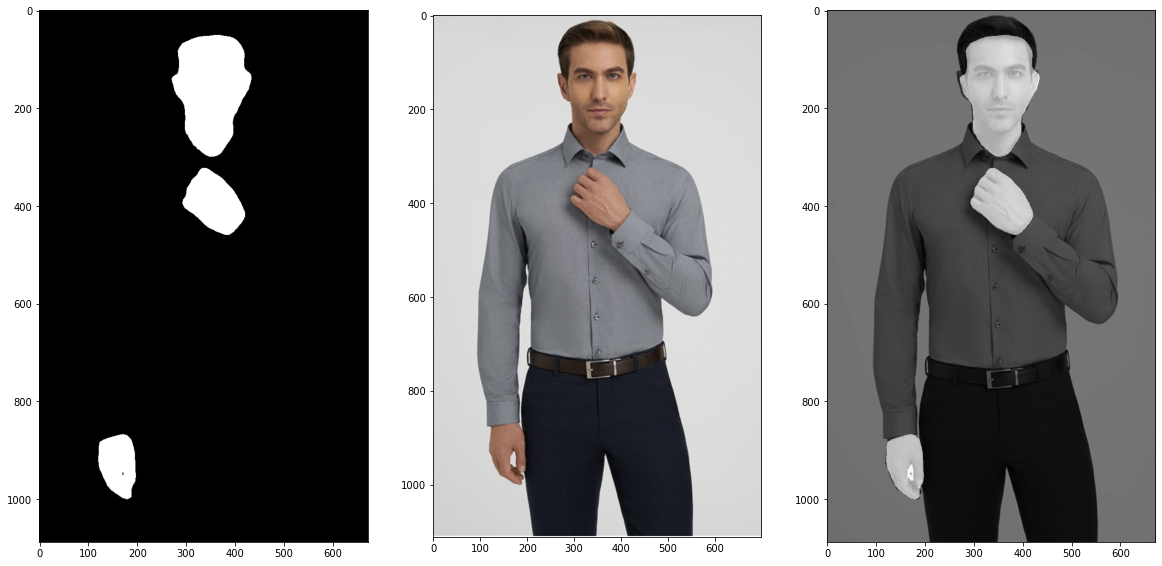

In [66]:
image_path ="data/henderson1.png"
original = cv2.imread(image_path)
# original=load_image(image_path)


mask,resized_image=createSkinMask(original)

gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
ontop = cv2.addWeighted(mask, 0.5, gray, 0.5, 0)

f, axarr = plt.subplots(1,3,figsize=(20, 15))
axarr[0].imshow(mask, cmap='gray')
axarr[1].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axarr[2].imshow(ontop , cmap='gray')

    


# Color correction

##basic test 

ave_color: [100 150 150   0]
desired_color: [238  75  43   0]
diff_color: [ 138  -75 -107    0]
diff_color new: [ 138  -75 -107]
shape patch_pixels : (100, 100, 3)


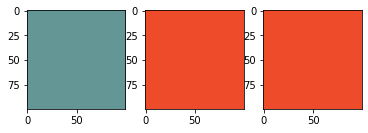

In [48]:

shape_of_colorimage1= (100, 100,3)

cimg1=np.ones(shape_of_colorimage1, dtype=np.int16)

cimg1[:,:,0]= cimg1[:,:,0]*100
cimg1[:,:,1]= cimg1[:,:,1]*150
cimg1[:,:,2]= cimg1[:,:,2]*150


cimg2=np.ones(shape_of_colorimage1, dtype=np.int16)


cimg2[:,:,0]= cimg2[:,:,0]*238
cimg2[:,:,1]= cimg2[:,:,1]*75
cimg2[:,:,2]= cimg2[:,:,2]*43


ave_color = cv2.mean(cimg1)
ave_color = np.asarray(ave_color, dtype=np.int16)
print("ave_color:",ave_color)


desired_color = cv2.mean(cimg2)
desired_color = np.asarray(desired_color, dtype=np.int16)
print("desired_color:",desired_color)


diff_color = desired_color - ave_color

print("diff_color:",diff_color)

diff_color =diff_color[:3]

print("diff_color new:",diff_color)

patch_pixels = np.full_like(cimg1, diff_color, dtype=np.int16)

print("shape patch_pixels :",patch_pixels.shape)

# dtype=cv2.CV_16F

new_img = cv2.add(cimg1, patch_pixels)


f, axarr = plt.subplots(1,3)
axarr[0].imshow(cimg1)
axarr[1].imshow(cimg2)
axarr[2].imshow(new_img)



##Test with real Image

We need 4 things. 

*   Desired color
*   Target image
*   Skin mask for Target image
*   Luck



###Read ColorSource Image

In [49]:
image_path2 ="/content/SkinDetectionExamples/src/data/target_head.png"
head = cv2.imread(image_path2)
head = cv2.cvtColor(head, cv2.COLOR_BGR2RGB)
head = head.astype('int16')

print("head.shape: ",head.shape)
print(head.dtype)

### Get skin pixel 
desired_color=head[75,100,:]
print(desired_color)

head.shape:  (244, 230, 3)
int16
[224 194 152]


###Read Target Image

In [69]:
image_path ="data/henderson1.png"
target=load_image(image_path)

target = target.astype('int16')
org_target= target.copy()
org_target=np.copy(target)

print("target.shape: ",target.shape)
print(target.dtype)

target.shape:  (1088, 672, 3)
int16


##Create skin mask for target image

In [51]:
# resized_mask=resized_mask*255

sample1=mask[950,190]
sample2=mask[10,190]
print(sample1)
print(sample2)

255
0


Apply color to target image using mask

In [67]:
def applyColorToTargetUsingMaskImage(target, mask,color):
    org_target= target.copy()
    target[(mask==255)] = color
    blended_img = cv2.addWeighted(target, 0.65, org_target, 0.35, 0)
    return blended_img



(1088, 672)


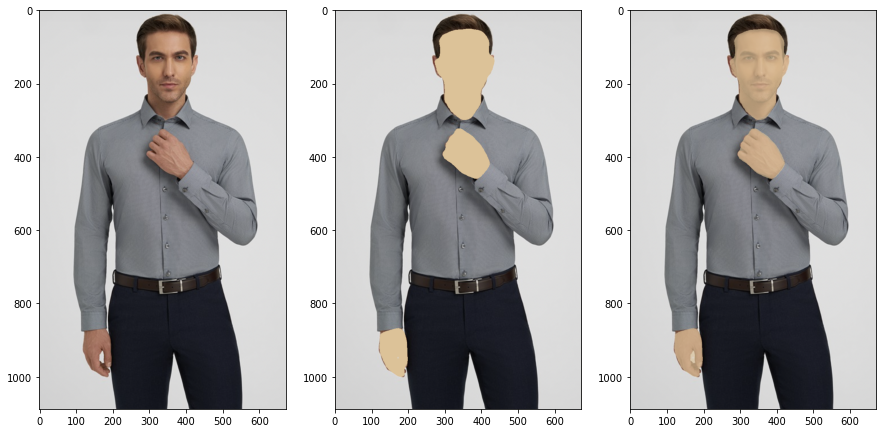

In [70]:

blended_img =applyColorToTargetUsingMaskImage(target, mask,[220 ,194 ,152])

f, axarr = plt.subplots(1,3, figsize=(15, 10))
axarr[0].imshow(org_target)
axarr[1].imshow(target)
axarr[2].imshow(blended_img)